In [1]:
from py2neo import Graph
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import pandas as pd
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

In [2]:
#neo4j grpah connection
 
graph = Graph("bolt://localhost:7687", auth=("neo4j", "letmein"))

In [3]:
#co-author graph for authors collaborating on same papers. 

query = """
CALL apoc.periodic.iterate(
  "MATCH (a1)<-[:AUTHOR]-(paper)-[:AUTHOR]->(a2:Author)
   WITH a1, a2, paper
   ORDER BY a1, paper.year
   RETURN a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations",
  "MERGE (a1)-[coauthor:CO_AUTHOR {year: year}]-(a2)
   SET coauthor.collaborations = collaborations", 
  {batchSize: 100})
"""

graph.run(query).data()

[{'batches': 3105,
  'total': 310448,
  'timeTaken': 31,
  'committedOperations': 310448,
  'failedOperations': 0,
  'failedBatches': 0,
  'retries': 0,
  'errorMessages': {},
  'batch': {'total': 3105, 'committed': 3105, 'failed': 0, 'errors': {}},
  'operations': {'total': 310448,
   'committed': 310448,
   'failed': 0,
   'errors': {}},
  'wasTerminated': False,
  'failedParams': {}}]

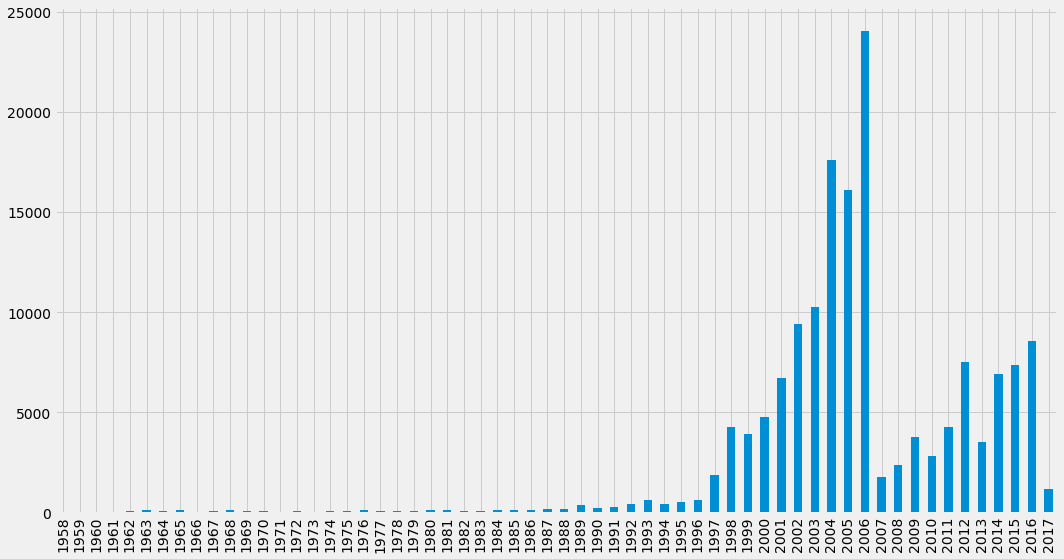

In [4]:
query = """
MATCH p=()-[r:CO_AUTHOR]->() 
WITH r.year AS year, count(*) AS count
ORDER BY year
RETURN toString(year) AS year, count
"""
by_year = graph.run(query).to_data_frame()

ax = by_year.plot(kind='bar', x='year', y='count', legend=None, figsize=(15,8))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

In [5]:
#train test split based on the year 2006 

query = """
MATCH (a)-[r:CO_AUTHOR]->(b) 
where r.year < 2006
MERGE (a)-[:CO_AUTHOR_EARLY {year: r.year}]-(b);
"""

graph.run(query).stats()

constraints_added: 0
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 81096
relationships_created: 81096
relationships_deleted: 0

In [6]:
#test data split
query = """
MATCH (a)-[r:CO_AUTHOR]->(b) 
where r.year >= 2006
MERGE (a)-[:CO_AUTHOR_LATE {year: r.year}]-(b);
"""

graph.run(query).stats()

constraints_added: 0
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 74128
relationships_created: 74128
relationships_deleted: 0

In [7]:
#count of train set
query = """
MATCH ()-[:CO_AUTHOR_EARLY]->()
RETURN count(*) AS count
"""

graph.run(query).to_data_frame()

,count
0,81096


In [8]:
# count of test set
query = """
MATCH ()-[:CO_AUTHOR_LATE]->()
RETURN count(*) AS count
"""

graph.run(query).to_data_frame()

,count
0,74128


In [9]:
#balance data
def down_sample(df):
    copy = df.copy()
    zero = Counter(copy.label.values)[0]
    un = Counter(copy.label.values)[1]
    n = zero - un
    copy = copy.drop(copy[copy.label == 0].sample(n=n, random_state=1).index)
    return copy.sample(frac=1)

In [10]:
train_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_EARLY]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

train_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_EARLY]-()
MATCH (author)-[:CO_AUTHOR_EARLY*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR_EARLY]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
train_missing_links = train_missing_links.drop_duplicates()

In [11]:
training_df = train_missing_links.append(train_existing_links, ignore_index=True)
training_df['label'] = training_df['label'].astype('category')
training_df = down_sample(training_df)

In [12]:
training_df.head()

,node1,node2,label
1040957,222024,222025,1
949799,258016,239451,0
240422,36667,245621,0
549229,107177,51846,0
1016287,50801,117912,1


In [13]:
test_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_LATE]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

test_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_LATE]-()
MATCH (author)-[:CO_AUTHOR_LATE*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR_LATE]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
test_missing_links = test_missing_links.drop_duplicates()

In [14]:
test_df = test_missing_links.append(test_existing_links, ignore_index=True)
test_df['label'] = test_df['label'].astype('category')
test_df = down_sample(test_df)

In [15]:
test_df.head()

,node1,node2,label
1289929,145729,145734,1
238134,58903,129359,0
1036433,217520,90568,0
1173416,242375,58642,0
1210760,252638,123762,0


In [16]:
#defining the machine learning algorthm to be used as recommender system
classifier = RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0)

In [17]:
#defeine link prediction algortihms

def apply_graph_features(data, rel_type):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           gds.alpha.linkprediction.commonNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS cn,
           gds.alpha.linkprediction.preferentialAttachment(
               p1, p2, {relationshipQuery: $relType}) AS pa,
           gds.alpha.linkprediction.totalNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS tn
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    features = graph.run(query, {"pairs": pairs, "relType": rel_type}).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [18]:
training_df = apply_graph_features(training_df, "CO_AUTHOR_EARLY")

In [19]:
training_df.head()

,node1,node2,label,cn,pa,tn
0,222024,222025,1,1.000,4.000,3.000
1,258016,239451,0,0.000,2.000,3.000
2,36667,245621,0,0.000,10.000,7.000
3,107177,51846,0,0.000,12.000,7.000
4,50801,117912,1,2.000,27.000,10.000


In [20]:
test_df = apply_graph_features(test_df, "CO_AUTHOR")

In [21]:
test_df.head()

,node1,node2,label,cn,pa,tn
0,145729,145734,1,10.000,121.000,12.000
1,58903,129359,0,0.000,10.000,7.000
2,217520,90568,0,0.000,204.000,55.000
3,242375,58642,0,0.000,13.000,14.000
4,252638,123762,0,1.000,15.000,7.000


In [22]:
#train random forest classifier
columns = ["cn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

RandomForestClassifier(max_depth=10, n_estimators=30, random_state=0)

In [23]:
def evaluate_model(predictions, actual):
    return pd.DataFrame({
        "Measure": ["Accuracy", "Precision", "Recall"],
        "Score": [accuracy_score(actual, predictions), 
                  precision_score(actual, predictions), 
                  recall_score(actual, predictions)]
    })

def feature_importance(columns, classifier):        
    display("Feature Importance")
    df = pd.DataFrame({
        "Feature": columns,
        "Importance": classifier.feature_importances_
    })
    df = df.sort_values("Importance", ascending=False)    
    ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None)
    ax.xaxis.set_label_text("")
    plt.tight_layout()
    plt.show()

,Measure,Score
0,Accuracy,0.854
1,Precision,0.944
2,Recall,0.753


'Feature Importance'

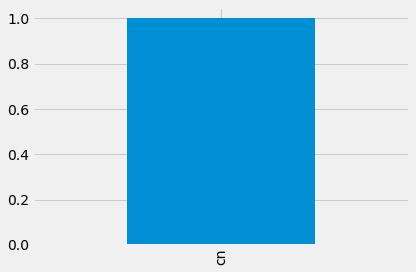

In [24]:
predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)

,Measure,Score
0,Accuracy,0.918
1,Precision,0.920
2,Recall,0.917


'Feature Importance'

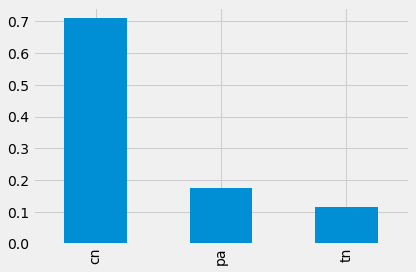

In [25]:
#building random forest classfieir with more features from all three chosen link prediction algorithms
columns = ["cn", "pa", "tn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)